In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os
import numpy as np

sys.path.append('..')
%aimport mre_pinn

sys.path.append('../../param_search')
%aimport param_search
ps = param_search

Using backend: pytorch



# Single-frequency 2D

## Solving the heterogeneous PDE in 2D at different frequencies

In this experiment, I am investigating whether we can fit and perform elasticity reconstruction using 2D wave images for a single frequency. I have been able to this somewhat successfully for the 80 Hz image, but I now am testing whether we can use each different frequency in isolation.

Both the single-frequency 1D experiment and the 2D Helmholtz interactive training notebook seem to confirm that the Helmholtz PDE is simply worse than the heterogeneous PDE, so I am only evaluating the hetero PDE here.

The last experiment did not clearly elucidate which omega0 and activation function are best, so we evaluate the same ranges as before in this experiment.

There are 6 different frequencies ranging from 50-100 Hz by 10 Hz increments.

In [7]:
mre_pinn.data.load_bioqic_dataset('../data/BIOQIC', 'fem_box')[0].frequency

Loading ../data/BIOQIC/four_target_phantom.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    u_ft: <class 'numpy.ndarray'> (100, 80, 10, 3, 6) complex128
Loading ../data/BIOQIC/fem_box_elastogram.npy
     <class 'numpy.ndarray'> (6, 10, 80, 100) complex128
Loading ../data/BIOQIC/fem_box_regions.npy
     <class 'numpy.ndarray'> (10, 80, 100) int64
Multi frequency 3D
<xarray.Dataset>
Dimensions:         (frequency: 6, x: 80, y: 100, z: 10, component: 3)
Coordinates:
  * frequency       (frequency) float64 50.0 60.0 70.0 80.0 90.0 100.0
  * x               (x) float64 0.0 0.001 0.002 0.003 ... 0.077 0.078 0.079
  * y               (y) float64 0.0 0.001 0.002 0.003 ... 0.097 0.098 0.099
  * z               (z) float64 0.0 0.001 0.002 0.003 ... 0.007 0.008 0.009
  * component       (component) <U1 'z' 'y' 'x'
Data variables:
    u               (frequency, x, y, z, component) complex128 (7.43590828448...
    mu              (frequency, x,

<xarray.DataArray 'frequency' (frequency: 6)>
array([ 50.,  60.,  70.,  80.,  90., 100.])
Coordinates:
  * frequency  (frequency) float64 50.0 60.0 70.0 80.0 90.0 100.0

In [10]:
# define the job template and name format

template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=bio170034p
#SBATCH --partition=BatComputer
#SBATCH --gres=gpu:rtx5000:1
#SBATCH --time=48:00:00
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
#SBATCH --mail-type=all

hostname
pwd
source activate MRE-PINN

python ../../../train.py \\
    --data_root ../../../data/BIOQIC \\
    --data_name fem_box \\
    --frequency {frequency} \\
    --xyz_slice {xyz_slice} \\
    --pde_name {pde_name} \\
    --omega0 {omega0} \\
    --n_layers {n_layers} \\
    --n_hidden {n_hidden} \\
    --activ_fn {activ_fn} \\
    --learning_rate {learning_rate} \\
    --pde_loss_wt {pde_loss_wt} \\
    --data_loss_wt {data_loss_wt} \\
    --batch_size {batch_size} \\
    --n_domain {n_domain} \\
    --n_iters {n_iters} \\
    --test_every {test_every} \\
    --save_every {save_every} \\
    --save_prefix {job_name}    
'''
name = 'train_{frequency}_{xyz_slice}_{pde_name}_{omega0}_{n_hidden}_{activ_fn}'

# define the parameter space

param_space = ps.ParamSpace(
    frequency=[50, 60, 70, 80, 90, 100],
    xyz_slice=['2D'],
    pde_name=['hetero'],
    omega0=[8, 16, 32],
    n_layers=5,
    n_hidden=16,
    activ_fn=['s', 't'],
    learning_rate=1e-4,
    pde_loss_wt=1,
    data_loss_wt=1e-8,
    batch_size=80,
    n_domain=128-80,
    pde_distrib='uniform',
    n_iters=100000,
    test_every=1000,
    save_every=10000
)

len(param_space)

36

In [11]:
%autoreload
expt_name = '2022-07-24_2D'

jobs = ps.submit(template, name, param_space, work_dir=expt_name, verbose=True)
jobs.to_csv(f'{expt_name}.jobs')

#jobs = pd.read_csv(f'{expt_name}.jobs')

100%|██████████| 36/36 [00:00<00:00, 137.46it/s]
[9951778, 9951779, 9951780, 9951781, 9951782, 9951783, 9951784, 9951785, 9951786, 9951787, 9951788, 9951789, 9951790, 9951791, 9951792, 9951793, 9951794, 9951795, 9951796, 9951797, 9951798, 9951799, 9951800, 9951801, 9951802, 9951803, 9951804, 9951805, 9951806, 9951807, 9951808, 9951809, 9951810, 9951811, 9951812, 9951813]


In [16]:
status_cols = ['job_name', 'job_state', 'node_id', 'runtime', 'stdout', 'stderr']
ps.status(jobs)[status_cols]

,job_name,job_state,node_id,runtime,stdout,stderr
job_id,,,,,,
9951778,train_50_2D_hetero_8_16_s,NaN,NaN,NaN,None,None
9951779,train_50_2D_hetero_8_16_t,NaN,NaN,NaN,None,None
9951780,train_50_2D_hetero_16_16_s,NaN,NaN,NaN,None,None
9951781,train_50_2D_hetero_16_16_t,NaN,NaN,NaN,None,None
9951782,train_50_2D_hetero_32_16_s,NaN,NaN,NaN,None,None
9951783,train_50_2D_hetero_32_16_t,NaN,NaN,NaN,None,None
9951784,train_60_2D_hetero_8_16_s,NaN,NaN,NaN,None,None
9951785,train_60_2D_hetero_8_16_t,NaN,NaN,NaN,None,None
9951786,train_60_2D_hetero_16_16_s,NaN,NaN,NaN,None,None


In [20]:
metrics = ps.metrics(jobs)

# did all models train to 100k iterations?
assert (metrics.groupby('job_name')['iteration'].max() == 100e3).all()

# get the final test evaluations
metrics = metrics[metrics.iteration == 100e3]

param_cols = ['frequency', 'omega0', 'activ_fn'] # experimental parameters
index_cols = ['variable_name', 'spatial_frequency_bin', 'spatial_region'] # metric identifiers
metric_cols = ['mean_squared_abs_value', 'power_density', 'mean_abs_value'] # metric values

metrics = metrics.groupby(param_cols + index_cols, sort=False)[metric_cols].mean().unstack(level=[3])

def metric_map(t):
    metric_name, var_name = t
    metric_name = {
        'mean_squared_abs_value': 'MSAV',
        'mean_abs_value': 'MAV',
        'power_density': 'SPD'
    }[metric_name]
    new_col_name = f'{var_name}_{metric_name}'
    new_col_name = new_col_name.replace('diff_MSAV', 'pred_MSAE')
    new_col_name = new_col_name.replace('f_sum_MSAV', 'PDE_MSAE')
    new_col_name = new_col_name.replace('diff_MAV', 'pred_MAD')
    return new_col_name

metrics.columns = [metric_map(t) for t in metrics.columns.to_flat_index()]

m = metrics.reset_index()
metrics

u_pred_MSAV  \
frequency omega0 activ_fn spatial_frequency_bin spatial_region                 
50        8      s        all                   all             1.434575e-10   
                                                0                        NaN   
                                                1                        NaN   
                                                2                        NaN   
                                                3                        NaN   
...                                                                      ...   
100       32     t        6.0                   all                      NaN   
                          7.0                   all                      NaN   
                          8.0                   all                      NaN   
                          9.0                   all                      NaN   
                          10.0                  all                      NaN   

                                                                 u_pred_MSAE  \
frequency omega0 activ_fn spatial_frequency_bin spatial_region                 
50        8      s        all                   all             8.853519e-12   
                                                0                        NaN   
                                                1                        NaN   
                                                2                        NaN   
                                                3                        NaN   
...                                                                      ...   
100       32     t        6.0                   all                      NaN   
                          7.0                   all                      NaN   
                          8.0                   all                      NaN   
                          9.0                   all                      NaN   
                          10.0                  all                      NaN   

                                                                 u_true_MSAV  \
frequency omega0 activ_fn spatial_frequency_bin spatial_region                 
50        8      s        all                   all             1.544610e-10   
                                                0                        NaN   
                                                1                        NaN   
                                                2                        NaN   
                                                3                        NaN   
...                                                                      ...   
100       32     t        6.0                   all                      NaN   
                          7.0                   all                      NaN   
                          8.0                   all                      NaN   
                          9.0                   all                      NaN   
                          10.0                  all                      NaN   

                                                                lu_pred_MSAV  \
frequency omega0 activ_fn spatial_frequency_bin spatial_region                 
50        8      s        all                   all                 0.043017   
                                                0                        NaN   
                                                1                        NaN   
                                                2                        NaN   
                                                3                        NaN   
...                                                                      ...   
100       32     t        6.0                   all                      NaN   
                          7.0                   all                      NaN   
                          8.0                   all                      NaN   
                          9.0                   all           

<IPython.core.display.Javascript object>


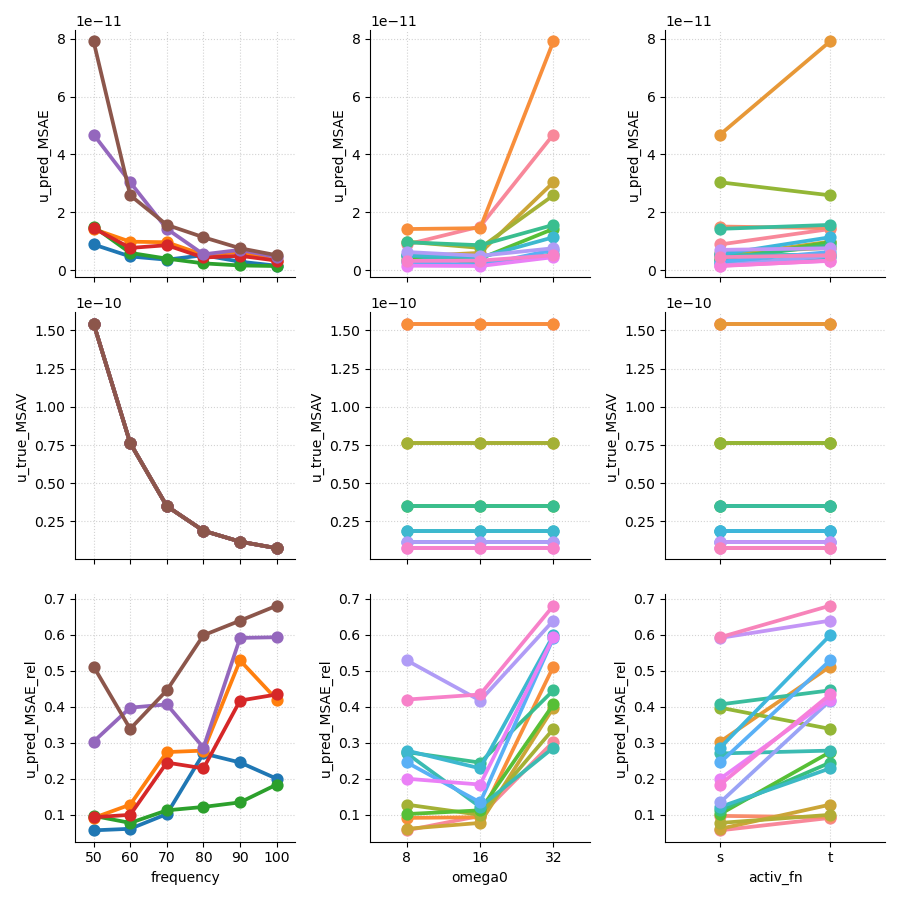

In [24]:
m['u_pred_MSAE_rel'] = m['u_pred_MSAE'] / m['u_true_MSAV']

fig = ps.plot(
    m,
    x=param_cols,
    y=['u_pred_MSAE', 'u_true_MSAV', 'u_pred_MSAE_rel'],
    height=3,
    width=3,
    legend=False,
    tight=True
)

There is a clear trend of lower wave field error at higher frequencies, but this mostly due to the higher frequency wave images having lower amplitude. We can correct for this by plotting the relative wave field error. In the relative error plot, we see the inverse trend: higher frequency wave images have higher relative error in the predicted wave field. This is probably related to the spectral bias of neural networks- it's easier for them to learn lower frequencies than higher ones.

There also is a nonlinear trend with respect to the omega0 parameter. Omega0 of 16 appears slightly better than 8, but a value of 32 is too high and the relative error is greatly increased.

<IPython.core.display.Javascript object>


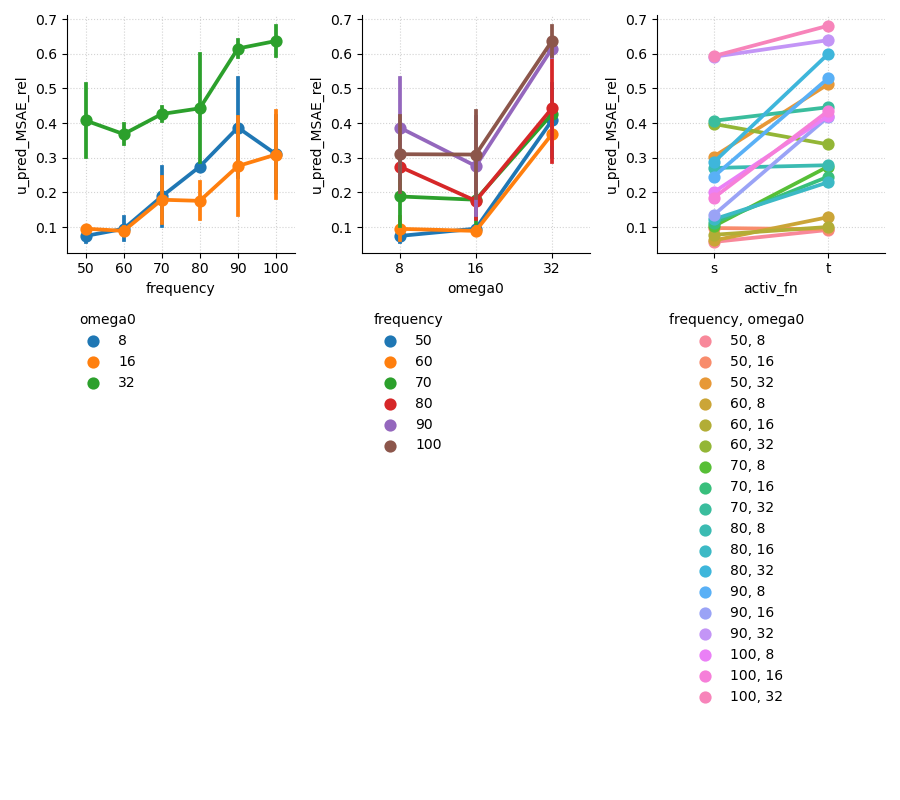

In [29]:
fig = ps.plot(
    m,
    x=param_cols,
    y=['u_pred_MSAE_rel'],
    hue=('frequency', 'omega0'),
    height=8,
    width=3,
    legend=True,
    tight=True
)

When grouping by both data frequency and model frequency (omega0), we see that the highest omega0 of 32 is clear worse across all data frequencies. The lower values of 8 and 16 perform similar across most data frequencies, except that omega0 of 16 is better at data frequencies 80 and 90.

<IPython.core.display.Javascript object>


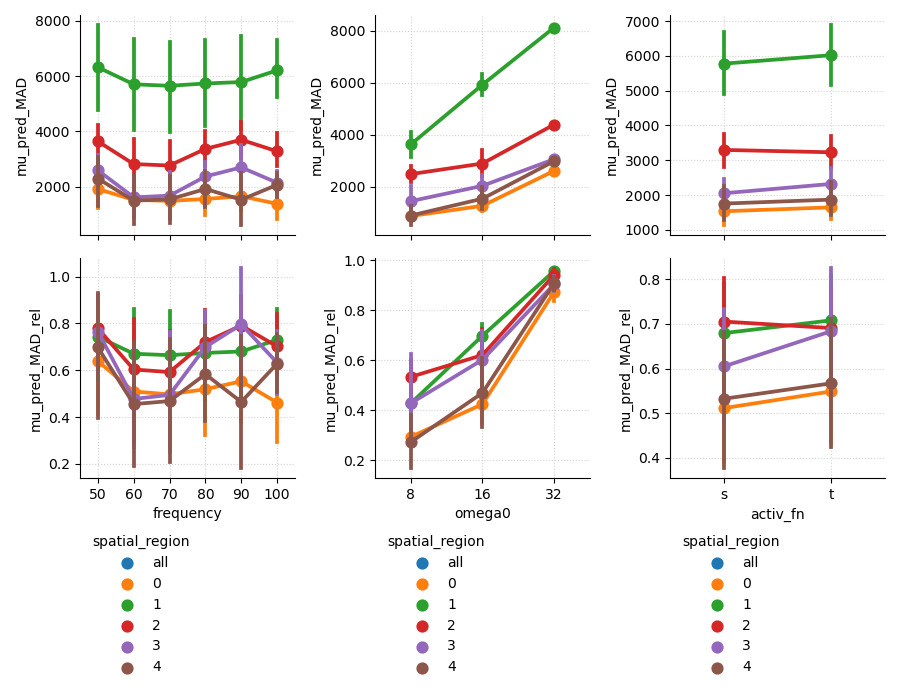

In [40]:
m['mu_pred_MAD_rel'] = m['mu_pred_MAD'] / m['mu_true_MAV']

fig = ps.plot(
    m,
    x=param_cols,
    y=['mu_pred_MAD', 'mu_pred_MAD_rel'],
    height=3.5,
    width=3,
    hue='spatial_region',
    legend=True,
    tight=True
)